In [198]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy
import torch

import sys
sys.path.append('..')  # we're in the notebooks directory, so we need to move up one for splice.py
sys.path.append("../../UberPhys/src")  # we need to add the UberPhys source directory to the path

from pyUberPhys.utilities.utilities import *
import matplotlib.colors as mcolors

from splice import splice_model

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print("Device:", device)

Device: mps


### Load the data

In [8]:
sim_name = 'random_18.9k'
train = pickle.load(
        open(os.path.join("..", "data", "lgn-v1", sim_name, f"{sim_name}_train.pkl"), "rb")
    )
test = pickle.load(
    open(os.path.join("..", "data", "lgn-v1", sim_name, f"{sim_name}_test.pkl"), "rb")
)

lgn_train = torch.Tensor(train["responses"]["lgn"]).to(device)
v1_train = torch.Tensor(train["responses"]["v1"]).to(device)

lgn_test = torch.Tensor(test["responses"]["lgn"]).to(device)
v1_test = torch.Tensor(test["responses"]["v1"]).to(device)

In [9]:
train['stim_params']

{'x': array([57, 75, 83, ..., 34, 54, 55], dtype=int32),
 'y': array([88, 92, 59, ..., 13, 24, 81], dtype=int32),
 'lgn_p': array([ 6.57859424, 15.93220285, 14.03879414, ..., 14.45749954,
         9.5201603 ,  2.838217  ]),
 'v1_p': array([ 2.35645809, 17.46052906,  9.90654501, ..., 11.88604735,
         9.0298937 ,  3.67505542]),
 'stim_arr': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])}

### Model architecture

In [10]:
model = splice_model(
    n_a = 400,
    n_b = 800,
    n_shared = 2,
    n_priv_a = 1,
    n_priv_b = 1,
    layers_enc = [200,200,200,200,200,200],
    layers_dec = [200,200,200,200,200,200],
    layers_msr = [200,200,200,200,200,200],
).to(device)

### Train/load model

In [11]:
trainNonIsomapModel = False
if trainNonIsomapModel:
    model.fit(lgn_train, v1_train, lgn_test, v1_test, disent_start=10000, c_disent=0.1, epochs=50000)
    torch.save(model.state_dict(), os.path.join("..", "results", "models", "lgn-v1", f"{sim_name}_splice.pt"))
else:
    model.load_state_dict(torch.load(os.path.join("..", "results", "models", "lgn-v1", f"{sim_name}_splice2.pt"), map_location=device))

### Iso: Train/Load model

In [196]:
trainIsomapModel = False
if trainIsomapModel:
    model.fit_isomap_splice(lgn_train, v1_train, lgn_test, v1_test, disent_start=10000, c_disent=0.1, epochs=50000, n_neighbors=200)
    torch.save(model.state_dict(), os.path.join("..", "results", "models", "lgn-v1", f"{sim_name}_splice_isomap.pt"))
else:
    model.load_state_dict(torch.load(os.path.join("..", "results", "models", "lgn-v1", f"{sim_name}_splice_isomap.pt"), map_location=device))

Text(0, 0.5, 'V1 private: v1_p')

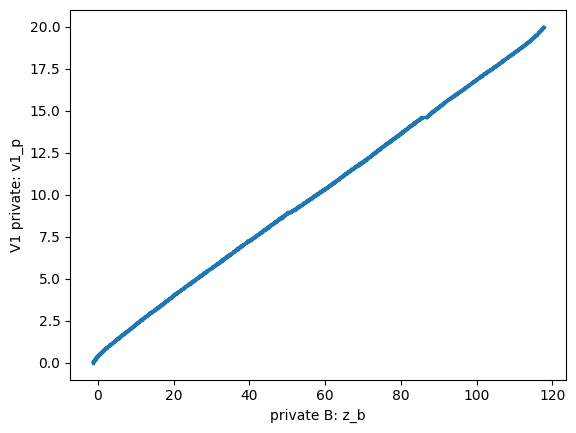

In [197]:
z_a, z_b2a, z_a2b, z_b, m_b2a, m_a2b, a_hat, b_hat = model(
                        lgn_test, v1_test
                    )
plt.scatter(z_b.detach().cpu().numpy(), test['stim_params']['v1_p'], s=2)
plt.xlabel('private B: z_b')
plt.ylabel('V1 private: v1_p')

### Plot Isomap shared space

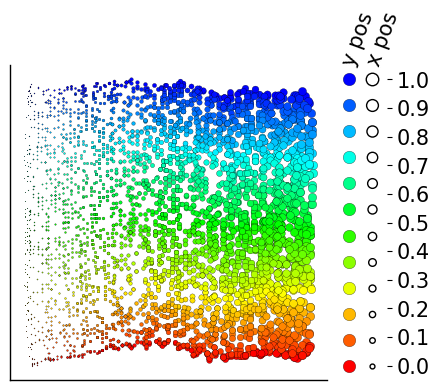

In [215]:
z_x, z_s_x, z_s_y, z_y, m_x, m_y, x_hat, y_hat = model(lgn_test, v1_test)

z_x = z_x.detach().cpu().numpy()
z_s_x = z_s_x.detach().cpu().numpy()
z_s_y = z_s_y.detach().cpu().numpy()
z_y = z_y.detach().cpu().numpy()

xpos_train = train["stim_params"]["x"]
ypos_train = train["stim_params"]["y"]
lgn_p_train = train["stim_params"]["lgn_p"]
v1_p_train = train["stim_params"]["v1_p"]

xpos_test = test["stim_params"]["x"]
ypos_test = test["stim_params"]["y"]
lgn_p_test = test["stim_params"]["lgn_p"]
v1_p_test = test["stim_params"]["v1_p"]

# colors for x and y positions, normalized to [0,1]
xcolrange = (xpos_test - xpos_test.min())/(xpos_test.max() - xpos_test.min())
ycolrange = (ypos_test - ypos_test.min())/(ypos_test.max() - ypos_test.min())

maxMarkerSize = 6
minMarkerSize = 0.5

# --------------------------------------------------------
#
#  Main plot
#
# --------------------------------------------------------

plt.figure(figsize=(10,10))
plt.subplot(2, 2, 1)    
for i in range(z_s_y.shape[0]):
    # Each point gets a color based on its x position
    red_blue = mcolors.to_rgb(mcolors.hsv_to_rgb([0.666 * xcolrange[i], 1.0, 1.0]))
    # Each point gets a size based on its y position
    plt.plot(-z_s_y[i,0], -z_s_y[i,1], 'o', color=red_blue, 
             markersize=ycolrange[i]*(maxMarkerSize-minMarkerSize)+minMarkerSize, 
             markeredgecolor='black', markeredgewidth=0.2)
# plt.title("LGN shared")
plt.xticks([]); plt.yticks([])
axisWidthChange(0.9, 'l')
axisHeightChange(0.9, 't')
# plt.gca().set_frame_on(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_linewidth(1)
plt.gca().spines['left'].set_linewidth(1)


# ----- add arrows to the axes -- not quite yet working -----
# from matplotlib.patches import FancyArrowPatch

# arrowprops=dict(arrowstyle="<|-", color="k", lw=1)
# xlim = plt.gca().get_xlim()
# ylim = plt.gca().get_ylim()
# # Adding arrowheads: x-axis and y-axis (start point, end point, arrow properties):
# plt.gca().add_patch(FancyArrowPatch((xlim[0], ylim[0]), (xlim[1], ylim[0]), **arrowprops))  # x-axis arrow
# plt.gca().add_patch(FancyArrowPatch((xlim[0], ylim[0]), (xlim[0], ylim[1]), **arrowprops))  # y-axis arrow
# # Adjust the axis limits to make sure arrows are fully visible
# plt.xlim(-49, 5)
# plt.ylim(-18, 1)
# ---- end add arrows ----

# --------------------------------------------------------
#
#  plot making legend for dot size and color
#
# --------------------------------------------------------
ax2 = plt.axes(position=plt.gca().get_position())
axisWidthChange(0.15, 'r')
axisMove(0.06, 0)
plt.xticks([]); plt.yticks([])
numItems = 12  # number of vertical color and dot size entries
for i in range(numItems):
    # First the colored dots
    red_blue = mcolors.to_rgb(mcolors.hsv_to_rgb([0.666 * i/(numItems-1), 1.0, 1.0]))
    plt.plot(0, i/(numItems-1), 'o', color=red_blue, 
             markersize=maxMarkerSize+3, 
             markeredgecolor='black', markeredgewidth=0.2)
    # Then the different sized dots
    plt.plot(1.2, i/(numItems-1), 'o', color='w',
             markersize=(i/11)*(maxMarkerSize-minMarkerSize)+minMarkerSize+3, 
             markeredgecolor='black', markeredgewidth=1)
    plt.xlim(-0.5,2)
plt.gca().set_frame_on(False)
plt.yticks(np.arange(0,1.1,0.1));
plt.gca().set_yticklabels(np.round(np.arange(0,1.1,0.1), 2), fontsize=15)
ax2.tick_params(axis='y', labelright=True, labelleft=False, left=False, right=True)
plt.text(-0.5, 1.05, "y pos", fontsize=15, rotation=70); # , transform=ax2.transAxes);
plt.text( 0.8, 1.05, "x pos", fontsize=15, rotation=70); # , transform=ax2.transAxes);


# --------------------------------------------------------
#
#  save the plot
#
# --------------------------------------------------------
plt.savefig("../Figures/isomap_shared_LGN.svg", bbox_inches='tight')



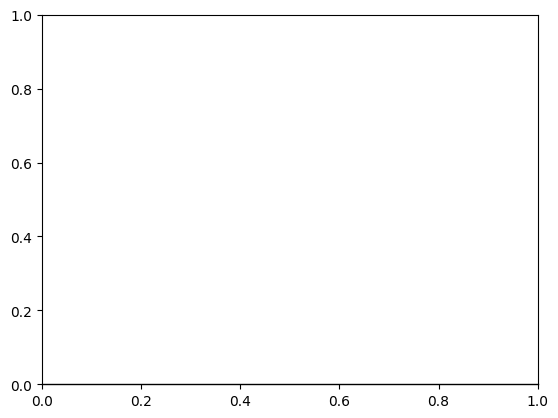

In [214]:
plt.gca().spines['bottom'].set_linewidth(1)

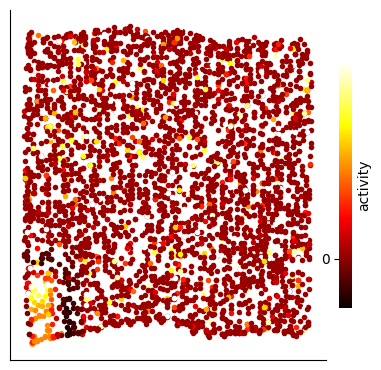

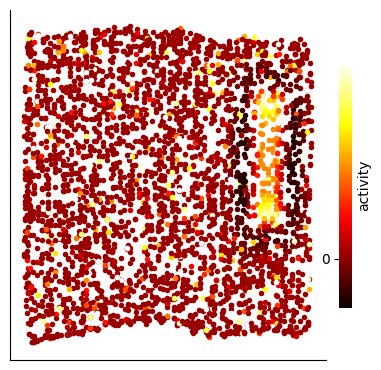

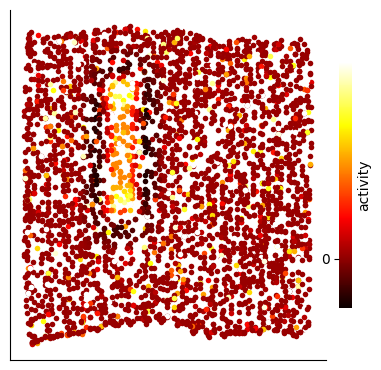

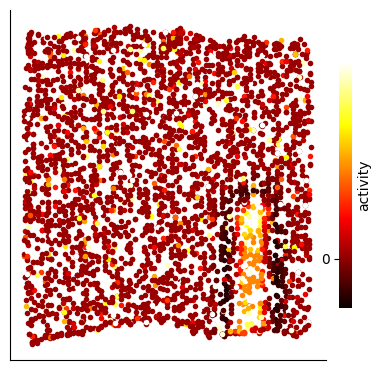

In [194]:
import matplotlib.colors as mcolors 
import matplotlib as mpl
for cellnum in (62, 236, 227, 135):

    lgn_scaled = (lgn_test - lgn_test.min()) / (lgn_test.max() - lgn_test.min())
    lgn_scaled = lgn_scaled.detach().cpu().numpy()


    plt.figure(figsize=(10,10))
    plt.subplot(2, 2, 1)    
    for i in range(z_s_y.shape[0]):
        red_blue = mcolors.to_rgb(mcolors.hsv_to_rgb([0.666 * (1-lgn_scaled[i,cellnum]), 1.0, 1.0]))
        blue_yellow = mcolors.to_rgb(mcolors.hsv_to_rgb([(0.1 + (0.777 - 0.1) * (1 - lgn_scaled[i,cellnum])), 1.0, 1.0]))
        plt.plot(-z_s_y[i,0], -z_s_y[i,1], 'o', color=mpl.colormaps['hot'](2.6*(lgn_scaled[i,cellnum]**2)), 
                markersize=4, 
                markeredgecolor='none', markeredgewidth=0.2)
        # plt.plot(-z_s_y[i,1], -z_s_y[i,0], 'o', color=red_blue, 
        #          markersize=2, 
        #          markeredgecolor='none', markeredgewidth=0.2)
    # plt.title("LGN shared")
    plt.xticks([]); plt.yticks([])
    axisWidthChange(0.9, 'l')
    axisHeightChange(0.9, 't')
    # plt.gca().set_frame_on(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)


    # Create a mappable object with the same colormap and normalization
    norm = mpl.colors.Normalize(vmin=lgn_scaled.min(), vmax=lgn_scaled.max())
    sm = mpl.cm.ScalarMappable(cmap=mpl.colormaps['hot'], norm=norm)
    sm.set_array([])  # You can set an empty list because the colorbar uses only the colormap and norm

    # Add the colorbar to the plot
    cax = plt.colorbar(sm, ax=plt.gca(), orientation='vertical').ax
    axisHeightChange(0.7, 'm', cax)
    cax.set_ylabel('activity')
    cax.set_frame_on(False)
    cax.yaxis.set_ticks_position('left')
    cax.set_yticks([0.2])
    cax.set_yticklabels(["0"])

    axisWidthChange(1.12, 'l')
    axisMove(0.03, 0, cax)

    plt.savefig("../Figures/cell_%d_onShared.svg" % cellnum, bbox_inches='tight')
    plt.savefig("../Figures/cell_%d_onShared.png" % cellnum, bbox_inches='tight', dpi=300)



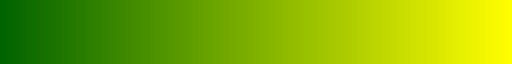

In [107]:
blue_yellow_cmap

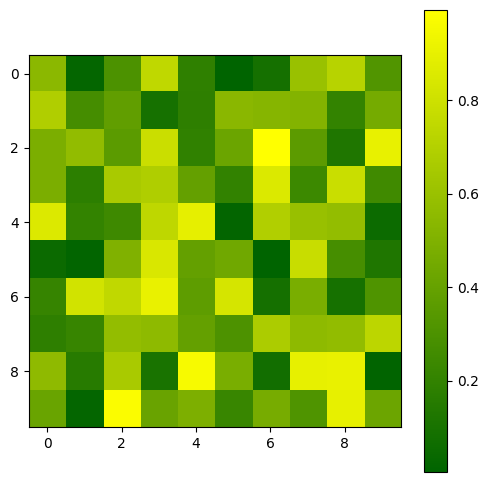

In [111]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

# Define the blue-yellow colormap
colors = ["darkgreen", "yellow"]  # Start with blue, end with yellow
cmap_name = "blue_yellow"
blue_yellow_cmap = LinearSegmentedColormap.from_list(cmap_name, colors)

# Example usage with imshow
# Generate some data to visualize
data = np.random.rand(10,10)

plt.figure(figsize=(6,6))
plt.imshow(data, cmap=blue_yellow_cmap)
plt.colorbar()  # Show color scale
plt.show()